In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
transformations = transforms.Compose([transforms.ToTensor(), 
                        transforms.Lambda(lambda img: img.squeeze().reshape(784))])

trans_target = lambda label: F.one_hot(torch.tensor(label), num_classes=10)


train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transformations , target_transform=trans_target)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transformations , target_transform=trans_target)

%config Completer.use_jedi = False


The label for this image is: 5


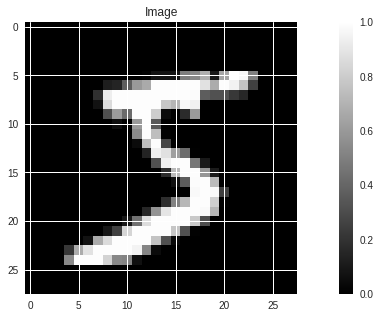

In [380]:
# Visualizing the images and lables
def visual(img):    
    fig, ax = plt.subplots()
    fig.set_size_inches(15,5)

    img = img.numpy().reshape(28, 28)
    im = ax.imshow(img, cmap=plt.cm.gray)
    fig.colorbar(im)
    ax.set_title("Image")
    
    
train_img = train_dataset[0][0]
print(f"The label for this image is: {train_dataset[0][1].argmax()}")
visual(train_img)

In [253]:
#Dataloader 
batch_size = 20
train_loader = DataLoader(
                dataset= train_dataset,
                batch_size=batch_size,
                shuffle=True) 
test_loader = DataLoader(
                dataset = test_dataset,
                batch_size=batch_size,
                shuffle=True)


In [348]:
class NeuralNet():
    def __init__(self, LR, batch_size):
        np.random.seed(0)

        self.layer1 = np.random.uniform(-0.5, 0.5, (784, 64))
        self.layer2 = np.random.uniform(-0.5, 0.5, (64, 10))
        self.batch_size = batch_size
        self.LR = LR
        
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))

    def softmax(self, z):
        ez = np.exp(z)

        sum_ez = np.sum(ez, axis=1, keepdims=True)        
        return ez / (sum_ez)
    
    def d_sigmoid(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))
    
    def d_softmax(self, a, y):
        result = np.sum((a-y).T * (np.diag(a.squeeze()) - np.multiply(a, a.T)), axis=0)
        return result
    
    def forward(self, x):
        self.x = x
        self.m1 = np.dot(x, self.layer1)
        self.z1 = self.sigmoid(self.m1)
        self.z2 = np.dot(self.z1, self.layer2)
        self.y_pred = self.softmax(self.z2)
        return self.y_pred
    
    def backpass(self, y):
        d_pred = np.empty((self.batch_size, 10))
        for i in range(self.batch_size):
            d_pred[i] = self.d_softmax(self.y_pred[i].reshape(1, -1), y[i].reshape(1, -1))
        
        d_m1 = self.d_sigmoid(self.m1) * (np.dot(d_pred, self.layer2.T))
        d_layer1 = 1/self.batch_size * np.dot(self.x.T, d_m1)
        d_layer2 = 1/self.batch_size * np.dot(self.z1.T, d_pred)


        self.layer1 = self.layer1 - self.LR * d_layer1
        self.layer2 = self.layer2 - self.LR * d_layer2

    
    def mse(self, y, pred):
        result = np.mean((pred - y)**2)
        return result

In [359]:
# Training
def training(EPOCHS = 500, print_every=25):
    loss_list = []
    for epoch in tqdm(range(EPOCHS)):
        total_loss = 0.0
        for x,y in train_loader:
            x,y = x.numpy(), y.numpy()
            pred = net.forward(x)
            loss = net.mse(y, pred)
            
            net.backpass(y)
            total_loss += loss

        loss_list.append(total_loss)
        
        if (epoch+1) % print_every == 0 or epoch == 0:
            print(f"Epoch {epoch + 1} has loss {total_loss}")
    return loss_list

In [364]:
LR = 0.1
net = NeuralNet(LR, batch_size)
loss_list = training()

  0%|                                           | 1/500 [00:07<58:38,  7.05s/it]

Epoch 1 has loss 129.28114759256576


  5%|██                                        | 25/500 [02:56<56:13,  7.10s/it]

Epoch 25 has loss 18.420819511805803


 10%|████▏                                     | 50/500 [05:53<52:54,  7.05s/it]

Epoch 50 has loss 11.797625556962798


 15%|██████▎                                   | 75/500 [08:49<49:53,  7.04s/it]

Epoch 75 has loss 8.674718175199601


 20%|████████▏                                | 100/500 [11:46<47:02,  7.06s/it]

Epoch 100 has loss 6.794869413060973


 25%|██████████▎                              | 125/500 [14:43<43:53,  7.02s/it]

Epoch 125 has loss 5.567025445478976


 30%|████████████▎                            | 150/500 [17:38<40:45,  6.99s/it]

Epoch 150 has loss 4.7035805385338465


 35%|██████████████▎                          | 175/500 [20:33<38:06,  7.03s/it]

Epoch 175 has loss 4.05202213642856


 40%|████████████████▍                        | 200/500 [23:29<35:13,  7.04s/it]

Epoch 200 has loss 3.5689952891254575


 45%|██████████████████▍                      | 225/500 [26:25<32:26,  7.08s/it]

Epoch 225 has loss 3.1989918228979444


 50%|████████████████████▌                    | 250/500 [29:21<29:19,  7.04s/it]

Epoch 250 has loss 2.899951533626789


 55%|██████████████████████▌                  | 275/500 [32:17<26:29,  7.07s/it]

Epoch 275 has loss 2.6463649617855376


 60%|████████████████████████▌                | 300/500 [35:13<23:31,  7.06s/it]

Epoch 300 has loss 2.433261152780257


 65%|██████████████████████████▋              | 325/500 [38:08<20:26,  7.01s/it]

Epoch 325 has loss 2.254156477329811


 70%|████████████████████████████▋            | 350/500 [41:03<17:26,  6.98s/it]

Epoch 350 has loss 2.1029727515714325


 75%|██████████████████████████████▊          | 375/500 [43:59<14:33,  6.99s/it]

Epoch 375 has loss 1.9780972534069508


 80%|████████████████████████████████▊        | 400/500 [46:55<11:44,  7.05s/it]

Epoch 400 has loss 1.8796813565191925


 85%|██████████████████████████████████▊      | 425/500 [49:50<08:49,  7.07s/it]

Epoch 425 has loss 1.795682514136462


 90%|████████████████████████████████████▉    | 450/500 [52:46<05:51,  7.02s/it]

Epoch 450 has loss 1.720928905361394


 95%|██████████████████████████████████████▉  | 475/500 [55:42<02:56,  7.07s/it]

Epoch 475 has loss 1.658210597598081


100%|█████████████████████████████████████████| 500/500 [58:39<00:00,  7.04s/it]

Epoch 500 has loss 1.6097516689814966


In [385]:
# Testing
def testing(test_loader, net):
    total_corr = 0
    for x, y in test_loader:
        output = net.forward(x)
        pred = torch.argmax(torch.Tensor(output), dim=1)
        gt = torch.argmax(y, dim=1)

        correct = torch.count_nonzero(pred == gt)
        total_corr += correct

    return (total_corr/len(test_dataset))

In [386]:
acc = testing(test_loader, net) * 100
print(f"The accuracy of the mdoel is: {acc:.2f}")

The accuracy of the mdoel is: 97.30


The label for this test image is: 7


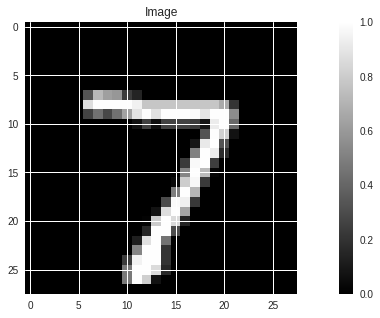

In [387]:
test_image = test_dataset[0][0]
visual(test_image)

output = net.forward(test_image.reshape(1, -1))
pred = torch.argmax(torch.Tensor(output), dim=1)
print(f"The label for this test image is: {pred.item()}")

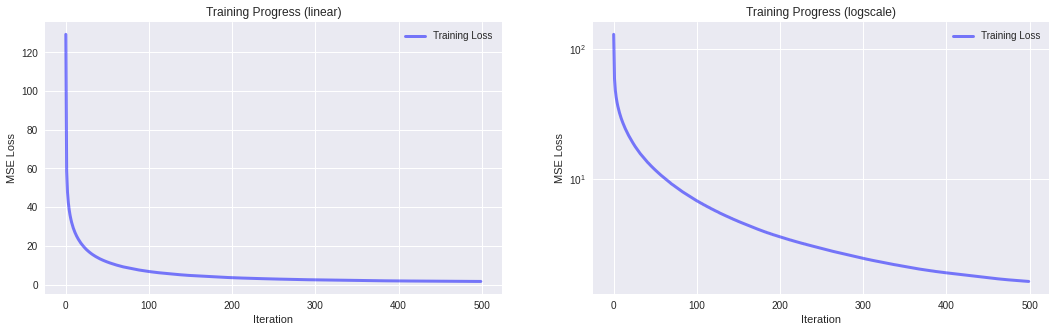

In [388]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(18, 5)

ax[0].plot(loss_list, c="blue", label="Training Loss", linewidth=3, alpha=0.5)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("MSE Loss")
ax[0].set_title("Training Progress (linear)")

ax[1].plot(loss_list, c="blue", label="Training Loss", linewidth=3, alpha=0.5)
ax[1].legend(loc="best")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("MSE Loss")
ax[1].set_yscale("log")
ax[1].set_title("Training Progress (logscale)")
plt.show()